In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, Trainer, TrainingArguments
import torch
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os
print(os.listdir('../input/emotion-dataset'))

['validation.csv', 'training.csv', 'test.csv']


In [ ]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("parulpandey/emotion-dataset")

# print("Path to dataset files:", path)

## Data Loading and Preprocessing:

In [3]:
dataset_name = 'emotion-dataset' 
train_file_name = 'training.csv'  
test_file_name = 'test.csv'  
val_file_name = 'validation.csv'  

# Construct the file paths
train_csv_file_path = f'../input/{dataset_name}/{train_file_name}'
test_csv_file_path = f'../input/{dataset_name}/{test_file_name}'
val_csv_file_path = f'../input/{dataset_name}/{val_file_name}'

# Load the datasets
train_df = pd.read_csv(train_csv_file_path)
test_df = pd.read_csv(test_csv_file_path)
val_df = pd.read_csv(val_csv_file_path)

In [4]:
print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(16000, 2)
(2000, 2)
(2000, 2)


In [5]:
train_df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [6]:
test_df.head()

,text,label
0,im feeling rather rotten so im not very ambiti...,0
1,im updating my blog because i feel shitty,0
2,i never make her separate from me because i do...,0
3,i left with my bouquet of red and yellow tulip...,1
4,i was feeling a little vain when i did this one,0


In [7]:
val_df.head()

,text,label
0,im feeling quite sad and sorry for myself but ...,0
1,i feel like i am still looking at a blank canv...,0
2,i feel like a faithful servant,2
3,i am just feeling cranky and blue,3
4,i can have for a treat or if i am feeling festive,1


In [8]:
unique_emotions = train_df['label'].value_counts()

# Display the unique emotions and their counts
print(unique_emotions)

label
1    5362
0    4666
3    2159
4    1937
2    1304
5     572
Name: count, dtype: int64


According to the dataset description:

sadness (0), joy (1), love (2), anger (3), fear (4), surprise (5).

In [9]:
emotion_mapping = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}

### Remove Null values if present

In [10]:
# Check for null values in each dataset
print("Null values in train_df:")
print(train_df.isnull().sum())

print("\nNull values in test_df:")
print(test_df.isnull().sum())

print("\nNull values in val_df:")
print(val_df.isnull().sum())

Null values in train_df:
text     0
label    0
dtype: int64

Null values in test_df:
text     0
label    0
dtype: int64

Null values in val_df:
text     0
label    0
dtype: int64


### Remove duplicates if present

In [11]:
print("Duplicate rows in train_df:", train_df.duplicated().sum())
print("Duplicate rows in test_df:", test_df.duplicated().sum())
print("Duplicate rows in val_df:", val_df.duplicated().sum())


Duplicate rows in train_df: 1
Duplicate rows in test_df: 0
Duplicate rows in val_df: 0


In [12]:
train_df.shape

(16000, 2)

In [13]:
train_df = train_df.drop_duplicates()

In [14]:
train_df.shape

(15999, 2)

### Remove Special Characters or numbers

In [15]:
import re

def clean_text(text):
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Keep only letters and spaces
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

train_df['text'] = train_df['text'].apply(clean_text)
test_df['text'] = test_df['text'].apply(clean_text)
val_df['text'] = val_df['text'].apply(clean_text)


## Visualization

In [16]:
#Class Distribution
def plot_class_distribution(labels, title):
    plt.figure(figsize=(8, 6))
    sns.countplot(x=labels, palette="viridis")
    plt.title(title, fontsize=16)
    plt.xlabel("Emotion Classes", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.show()


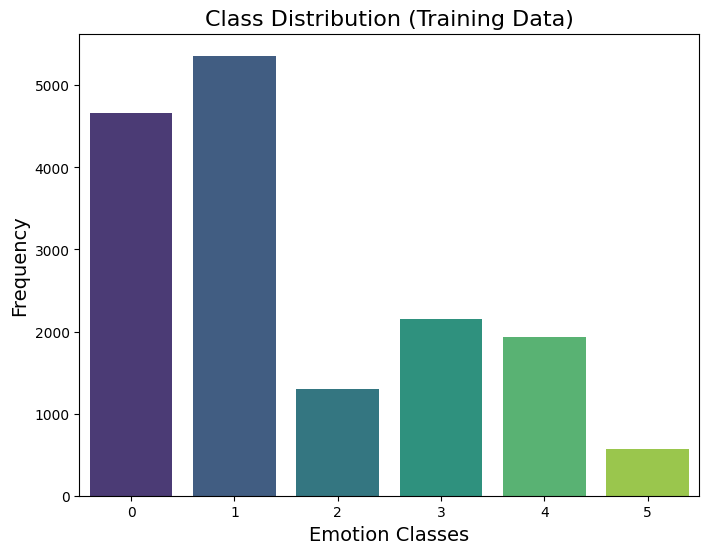

In [17]:
plot_class_distribution(train_df['label'], "Class Distribution (Training Data)")

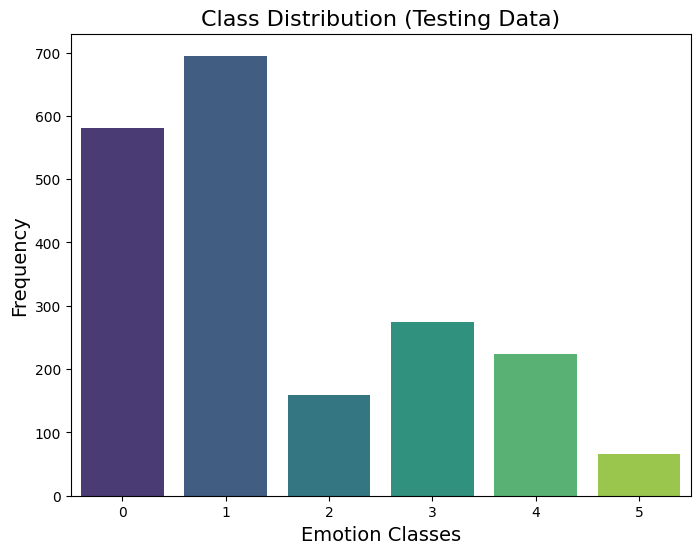

In [18]:
plot_class_distribution(test_df['label'], "Class Distribution (Testing Data)")

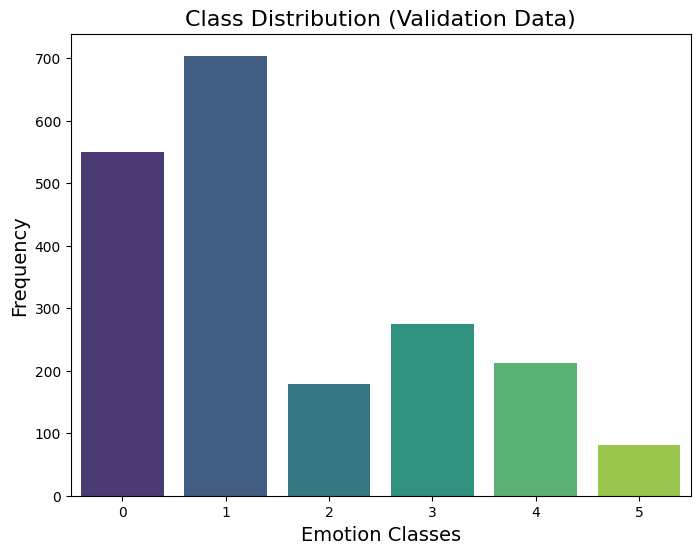

In [19]:
plot_class_distribution(val_df['label'], "Class Distribution (Validation Data)")

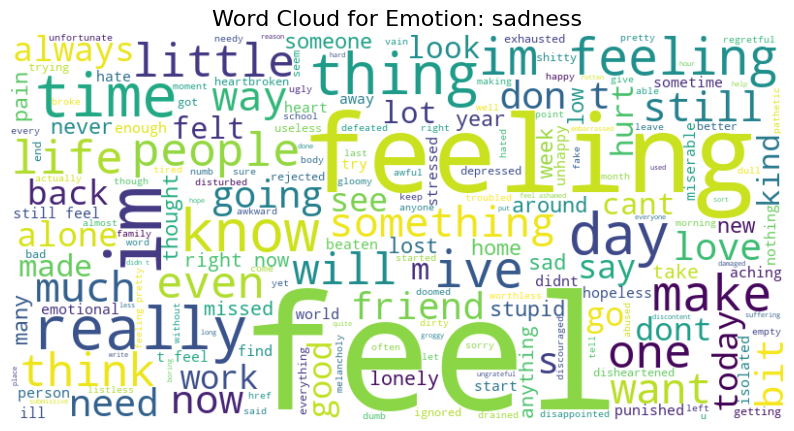

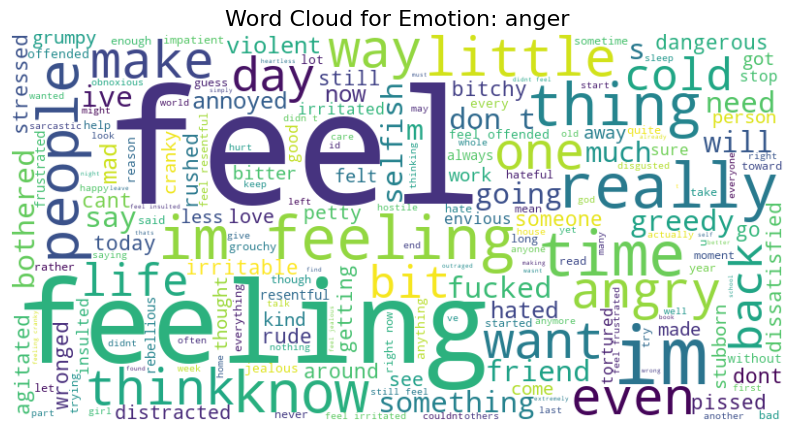

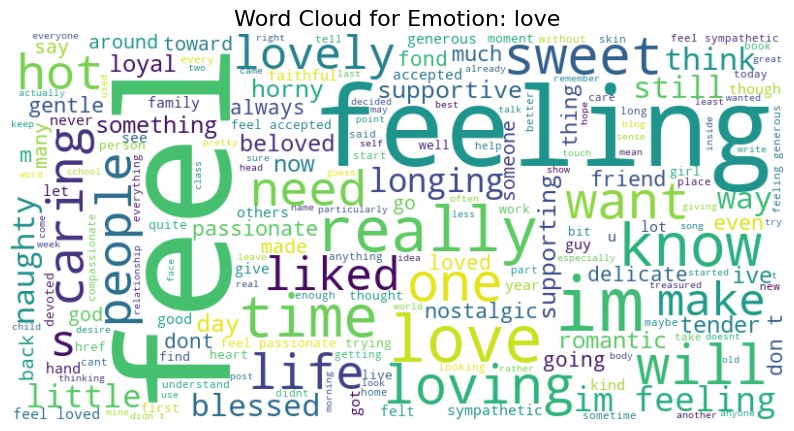

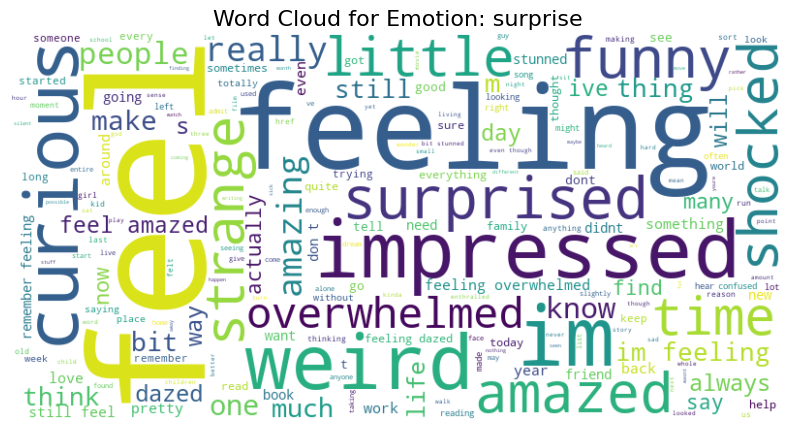

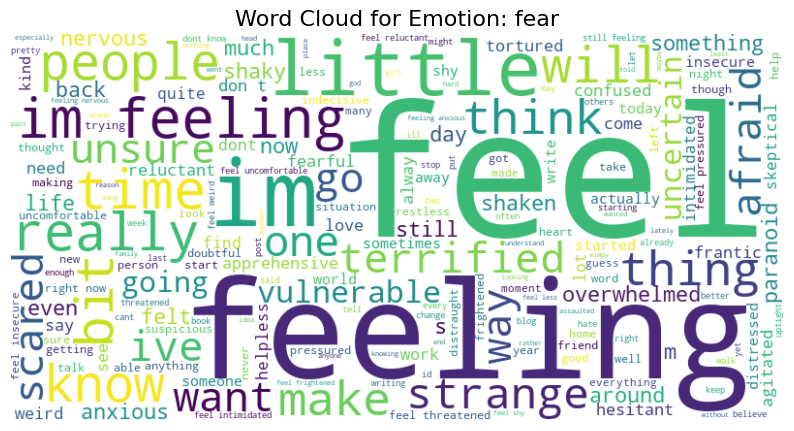

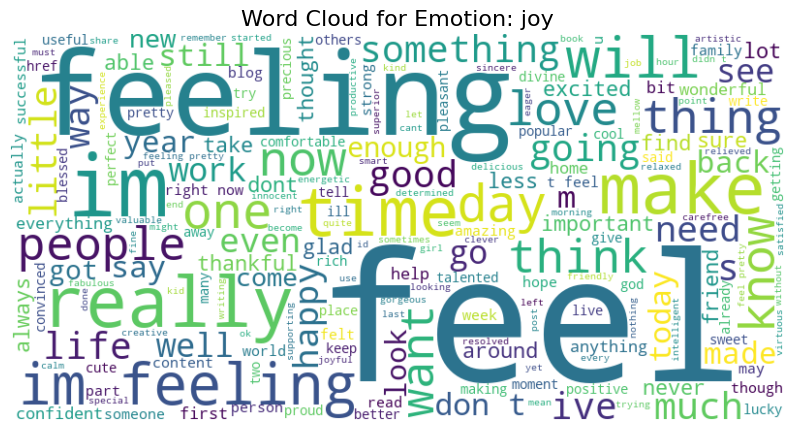

In [20]:
from wordcloud import WordCloud

def generate_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(text))
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

for label in train_df['label'].unique():
    emotion_name = emotion_mapping[label]
    text_data = train_df[train_df['label'] == label]['text']
    generate_word_cloud(text_data, f"Word Cloud for Emotion: {emotion_name}")


## Modeling

In [21]:
#clear GPU cache
import torch
torch.cuda.empty_cache()

In [22]:
# Convert DataFrames to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)
val_dataset = Dataset.from_pandas(val_df)

In [23]:
# Load the tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token #padding using end-of-sequence token to get all sentences to same length

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [24]:
#this function tokenize the sequence. 
#If sequence length is less than 128 than do padding. 
#If length is more than 128 then truncate.
def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding="max_length", max_length=128)

In [25]:
#use map to apply tokenize_function to each sequence in df and use batched=True to speed up the process
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/15999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [26]:
#Since we have tokenised the text to numerical representation so we no longer need plain text.
train_dataset = train_dataset.remove_columns(["text"])
test_dataset = test_dataset.remove_columns(["text"])
val_dataset = val_dataset.remove_columns(["text"])

In [27]:
# PyTorch format
#convert list to tensors, compatible with pytorch
train_dataset.set_format("torch")
test_dataset.set_format("torch")
val_dataset.set_format("torch")

In [28]:
# Initialize the model
model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=len(emotion_mapping))
# Set the default embedding layer to accomodate new tokens/vocabulary
model.resize_token_embeddings(len(tokenizer)) 

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Embedding(50257, 768)

In [29]:
#set the padding token ID for the model to that of the tokenizer, and ensure that the model correctly handles padding tokens in the input
model.config.pad_token_id = tokenizer.pad_token_id

In [30]:
from sklearn.metrics import accuracy_score

def compute_metrics(p):
    predictions, labels = p
    preds = predictions.argmax(axis=-1) #extract class corresponding to maximum value in list 
    accuracy = accuracy_score(labels, preds)
    return {"accuracy": accuracy}

In [32]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    logging_dir="./logs",
    learning_rate=5e-5,
    per_device_train_batch_size=4,
    num_train_epochs=2,
    weight_decay=0.01, #to penalize large weights
    report_to="none",  # Disable W&B logging
    logging_steps=50
)

In [33]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset, 
    compute_metrics=compute_metrics,
)

In [34]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,0.249500,0.178406,0.940500
2,0.105700,0.136662,0.946000


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

TrainOutput(global_step=4000, training_loss=0.29083712434768677, metrics={'train_runtime': 1015.7204, 'train_samples_per_second': 31.503, 'train_steps_per_second': 3.938, 'total_flos': 2090318849114112.0, 'train_loss': 0.29083712434768677, 'epoch': 2.0})

In [36]:
# Save the model
model_save_path = "./final_model"
trainer.save_model(model_save_path)  # Saves the model and tokenizer to the specified directory
tokenizer.save_pretrained(model_save_path)  # Save tokenizer as well

('./final_model/tokenizer_config.json',
 './final_model/special_tokens_map.json',
 './final_model/vocab.json',
 './final_model/merges.txt',
 './final_model/added_tokens.json')

## Results and Evaluation

In [37]:
# After training, evaluate the model on the test dataset
test_results = trainer.evaluate(test_dataset)

# Print test results
print(test_results)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 0.17025277018547058, 'eval_accuracy': 0.9285, 'eval_runtime': 14.1734, 'eval_samples_per_second': 141.109, 'eval_steps_per_second': 8.819, 'epoch': 2.0}


In [38]:
#evaluation matrix
# Get predictions and labels from the test dataset
predictions_output = trainer.predict(test_dataset)
predictions = predictions_output.predictions
labels = predictions_output.label_ids

# Convert log values to predicted class indices
predicted_classes = predictions.argmax(axis=-1)


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [40]:
from sklearn.metrics import classification_report, confusion_matrix

# Convert dictionary values to a list
target_names = list(emotion_mapping.values())

print("Evaluation Metrics:")
print(classification_report(labels, predicted_classes, target_names=target_names))

accuracy = accuracy_score(labels, predicted_classes)
print(f"Accuracy: {accuracy:.2f}")


Evaluation Metrics:
              precision    recall  f1-score   support

     sadness       0.97      0.97      0.97       581
         joy       0.95      0.95      0.95       695
        love       0.83      0.86      0.84       159
       anger       0.94      0.92      0.93       275
        fear       0.88      0.89      0.88       224
    surprise       0.68      0.76      0.72        66

    accuracy                           0.93      2000
   macro avg       0.88      0.89      0.88      2000
weighted avg       0.93      0.93      0.93      2000

Accuracy: 0.93


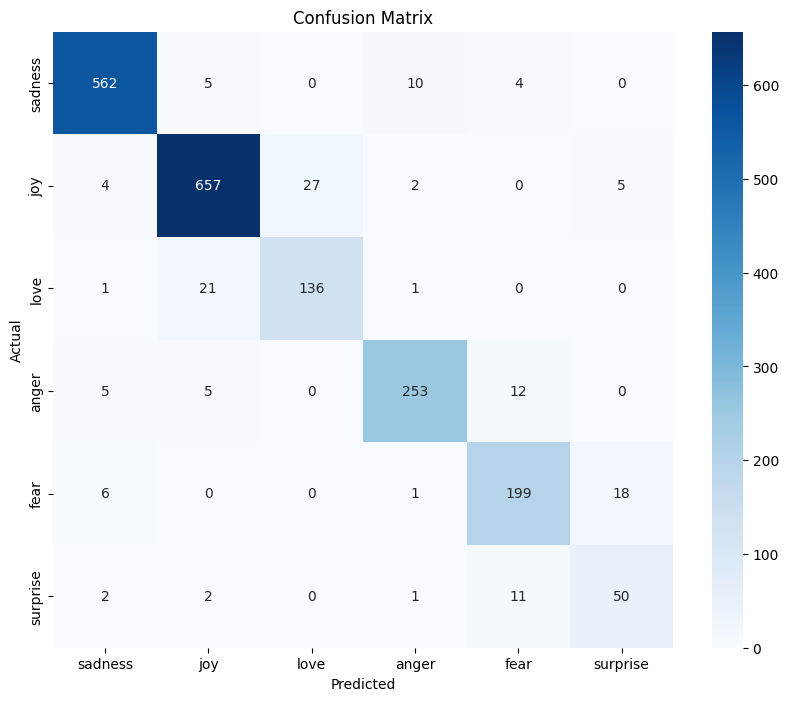

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
conf_matrix = confusion_matrix(labels, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=emotion_mapping.values(), yticklabels=emotion_mapping.values())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


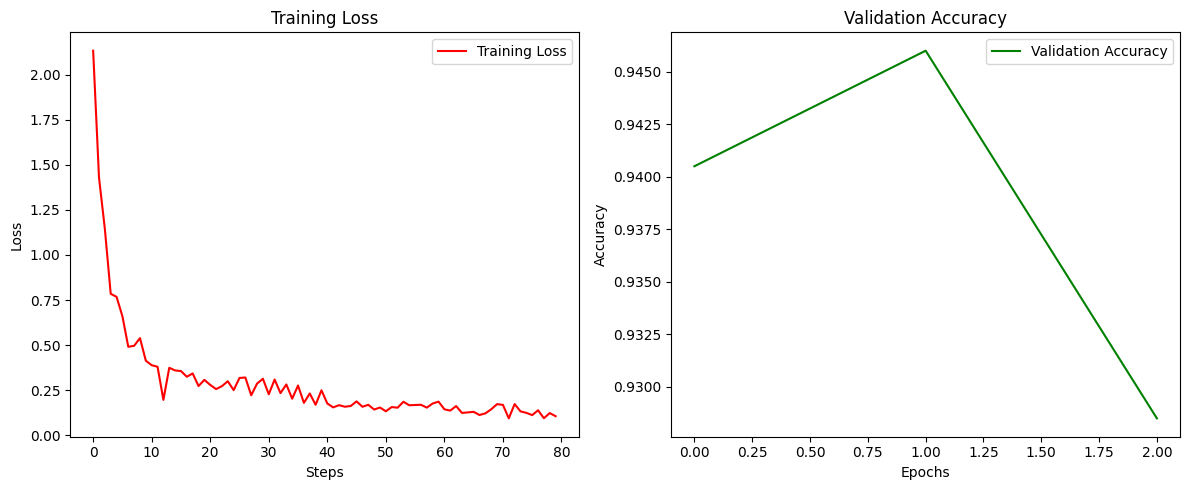

In [42]:
# Visualize Training and Evaluation Losses and Accuracy
import numpy as np

# Read the logs for the training
from transformers import TrainerCallback, TrainingArguments

# Access the log data
logs = trainer.state.log_history

# Separate loss and accuracy for visualization
train_loss = [log['loss'] for log in logs if 'loss' in log]
train_accuracy = [log['eval_accuracy'] for log in logs if 'eval_accuracy' in log]

# Plot the loss and accuracy curves
plt.figure(figsize=(12, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label="Training Loss", color="red")
plt.title("Training Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label="Validation Accuracy", color="green")
plt.title("Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

## Model saving and download

In [43]:
import torch

# Save the model
model_save_path = "/kaggle/working/gpt2_sequence_classification_model.pt"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to /kaggle/working/gpt2_sequence_classification_model.pt


## Load the emotion prediction model

In [9]:
import torch
from transformers import GPT2ForSequenceClassification, GPT2Tokenizer

# Define the model path
model_path = "gpt2_sequence_classification_model.pt"

# Load the model weights and map to CPU
state_dict = torch.load(model_path, map_location=torch.device("cpu"))

# Initialize the model with the correct number of labels
model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=6)
model.load_state_dict(state_dict)
model.eval()  # Put the model in evaluation mode

# Define the tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # Set the padding token


C:\Users\Ariba\AppData\Local\Temp\ipykernel_12416\4103618067.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=torch.devic

In [10]:
import torch.nn.functional as F
def predict_emotion(user_input):
    # Tokenize input
    inputs = tokenizer(user_input, return_tensors="pt", padding=True, truncation=True, max_length=128)

    # Get model output
    with torch.no_grad():
        outputs = model(**inputs)

    # Get logits and probabilities
    logits = outputs.logits
    probs = F.softmax(logits, dim=-1)

    # Get predicted class
    predicted_class = torch.argmax(probs, dim=-1).item()

    # Map class to emotion
    emotion_mapping = {0: "sadness", 1: "joy", 2: "love", 3: "anger", 4: "fear", 5: "surprise"}
    predicted_emotion = emotion_mapping[predicted_class]
    
    return predicted_emotion

## Load text generation model

In [2]:
import google.generativeai as genai
import os

genai.configure(api_key=os.environ["API_KEY"])

In [6]:
user_input = input('Enter story description: ')

model = genai.GenerativeModel('gemini-1.5-flash-latest')
    
flag = True
print_flag = False

while flag:
    if print_flag:
        user_input = input('Enter story description again (it should be descriptive and have one character only): ')
    else:
        print_flag = True 
        
    prompt = 'Return number of the humans in the prompt. Just return number. '
    prompt += user_input
    response = model.generate_content(prompt).text.lower().strip()
#     print(response)
    if response != '1':
        continue
    
    prompt = "Please return 'acceptable' if the user provided prompt is decriptive enough to generate a meaningful story."
    prompt += user_input
    response = model.generate_content(prompt).text.lower().strip()
#     print(response)
    if response == 'acceptable':
        flag = False


predicted_emotion = predict_emotion(user_input)
print('Predicted emotion: ', predicted_emotion)
        
print('\n')

word_count = '3000'
prompt = 'Generate a family friendly story. '
prompt += 'Use engaging paragraphs. '
prompt += 'The story should have a clear beginning, middle, and end. '
prompt += 'The character should not be carrying any stuff like bag. '
prompt += 'The main character should be alone, with no significant mention of any other human character in the story. '
prompt += 'All dialogue should be only the thoughts of the main character, in quotation marks. '
prompt += f'The length of story should be approximately {word_count} words. '
prompt += f'The story should have {predicted_emotion} emotion throughout to ensure emotionally resonant story. '
prompt += 'The description of the story is: '
prompt += user_input

response = model.generate_content(prompt)

print(response.text)

Enter story description: A boy wandering hopelessly in a deserted town
Predicted emotion: fear


The rusty swing set creaked a mournful song in the wind, the only sound besides the frantic thump-thump-thump of Leo’s heart. He stood frozen, staring at the deserted street stretching before him like a yawning chasm.  Dust devils danced in the sun-baked road, swirling around cracked pavements and crumbling buildings, silent witnesses to his growing terror.  He’d been following a flash of blue – a bluebird, he thought, something bright and hopeful in this desolate place – but it had vanished, leaving him utterly alone.  "Where am I?" he thought, his voice a whisper swallowed by the oppressive silence.  "This isn't right. This isn't right at all."

The town was a ghost town, a forgotten relic swallowed by time and neglect.  Buildings leaned at precarious angles, their windows like empty eyes staring out at the endless, unforgiving sky.  Paint peeled from the weathered wood, hanging in strips

## Conclusion

This project allowed us to explore and implement the application of GPT-2 for sequence classification in the domain of emotion detection and Gemini for story generation. Through the process of model loading, fine-tuning, and evaluation, we built a system that can classify textual input into six distinct emotion categories: sadness, joy, love, anger, fear, and surprise. We learned techniques for efficiently managing model inputs, including truncation, padding, and tokenizer configuration. Moreover, we learned to apply prompt engineering to guide pre-trained model Gemini towards a specific outcome. The Gemini model is instructed to generate a story with a specific emotion (predicted_emotion) that was detected from the user's input. This allowed the generated story to align with a particular emotional tone. We validated the input using prompt engineering to ensure that it is 'acceptable' and can be used to generate non-harmful content. We ensured that the story adheres to a specific criteria that includes family friendly and cohesive story. Thus, we gained valuable insights about model fine-tuning, evaluation and prompt engineering to create meaningful and user-aligned content.